# Analyse public tags added to Trove

This notebook loads public tags that users have added to records in Trove from the CSV file [harvested by this notebook](harvest-tags.ipynb). It then attempts some analysis of the tags.

The complete CSV is too large to store on GitHub. You can download it from [Zenodo](https://doi.org/10.5281/zenodo.5094314).

User content added to Trove, including tags, is available for reuse under a CC-BY-NC licence.

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import altair as alt
import pandas as pd
from wordcloud import WordCloud

In [2]:
# You will need to download the CSV file first from CloudStor or Zenodo
df = pd.read_csv("trove_tags_20240606.csv")

## Tags by zone

In [3]:
df["zone"].value_counts()

zone
newspaper     9537321
book           574038
gazette         98025
picture         96420
music           54840
article         24088
list             7717
map              7015
collection       4186
Name: count, dtype: int64

## How many duplicates across zones?

A single resource in Trove can appear in multiple zones – for example, a book that includes maps and illustrations might appear in the 'book', 'picture', and 'map' zones. This means that some of the tags will essentially be duplicates – harvested from different zones, but relating to the same resource. We can quantify this by finding put how many tags there are in the overlapping 'book', 'article', 'picture', 'music', 'map', and 'collection' zones, then dropping duplicates based on the `tag`, `date` and `record_id` fields.

In [4]:
# Total tags across overlapping zones
df.loc[
    df["zone"].isin(["book", "article", "picture", "music", "map", "collection"])
].shape

(760587, 4)

Now let's remove the duplicates and see how many are left.

In [5]:
df.loc[
    df["zone"].isin(["book", "article", "picture", "music", "map", "collection"])
].drop_duplicates(subset=["tag", "date", "record_id"]).shape

(700446, 4)

So there's about 50,000 'duplicates'. This doesn't really matter if you want to examine tagging behaviour within zones, but if you're aggregating tags across zones you might want to remove them, as demonstrated below.

## Top tags!

If we're going to look at the most common tags across all zones, then we should probably remove the duplicates mentioned above first.

In [6]:
# Dedupe overlapping zones
deduped_works = df.loc[
    df["zone"].isin(["book", "article", "picture", "music", "map", "collection"])
].drop_duplicates(subset=["tag", "date", "record_id"])

# Non overlapping zones
other_zones = df.loc[df["zone"].isin(["newspaper", "gazette", "list"])]

# Combine the two to create a new deduped df
deduped = pd.concat([deduped_works, other_zones])

In [7]:
deduped.shape

(10343509, 4)

Now let's view the 50 most common tags.

In [8]:
deduped["tag"].value_counts()[:50]

tag
north shore                          46393
lrrsa                                37671
illustration type cartoon            31980
tccc                                 29145
l1                                   25660
poem                                 24755
north sydney council                 23667
australian colonial music            23581
crossword puzzle                     21113
gag cartoon                          20625
political cartoon                    19788
melbourne football club              19224
crossword puzzle solution            19081
fiction                              16955
slvfix                               16860
corrected in full                    16732
tbd                                  15659
australian laureates                 14298
police court                         14037
rowing & sculling                    13986
serials                              12686
cammeray golf club                   12241
weather map                          12056
captain

Let's convert the complete tag counts into a new dataframe, and save it as a CSV file.

In [9]:
tag_counts = deduped["tag"].value_counts().to_frame().reset_index()
tag_counts.columns = ["tag", "count"]

In [10]:
tag_counts.to_csv("trove_tag_counts_20240606.csv", index=False)

Let's display the top 200 tags as a word cloud.

In [11]:
# Get the top 200 tags
top_200 = tag_counts[:200].to_dict(orient="records")

In [12]:
# Reshape into a tag:count dictionary.
top_200 = {tag["tag"]: tag["count"] for tag in top_200}

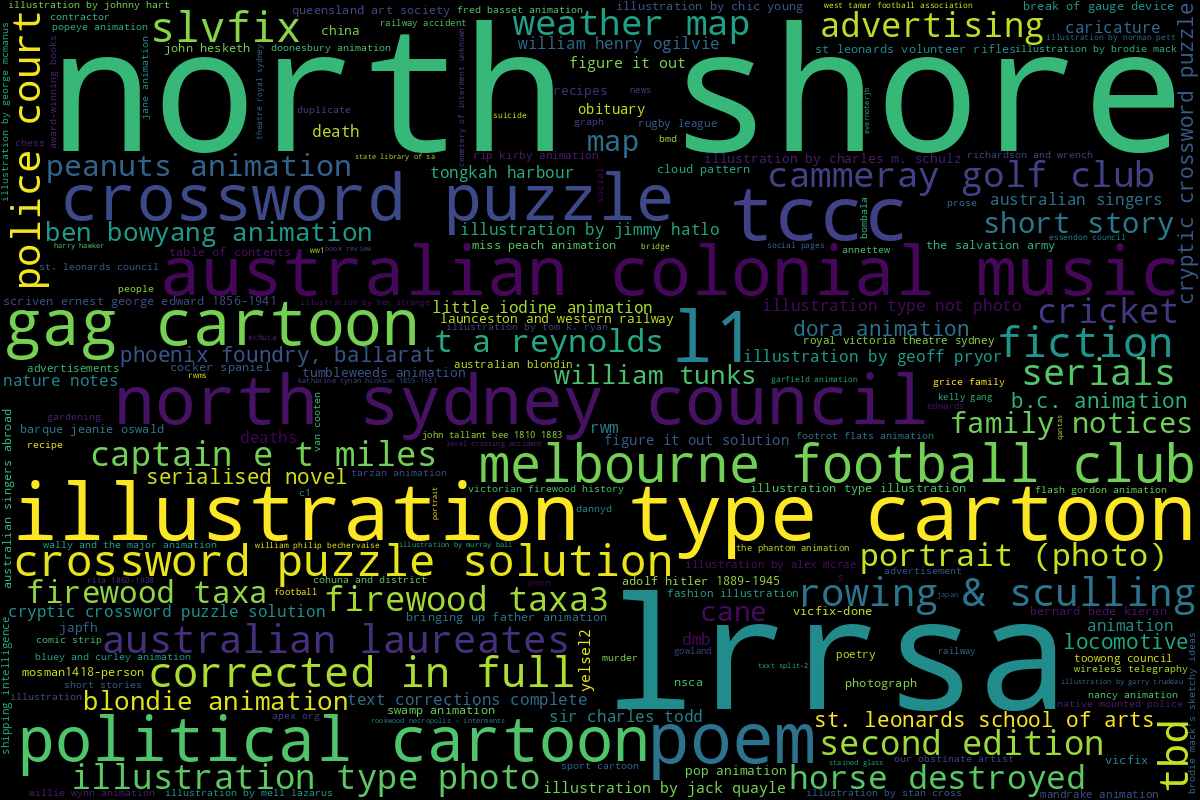

In [13]:
WordCloud(width=1200, height=800).fit_words(top_200).to_image()

## Tags on pictures

Most of the tags are on newspaper articles, but we can filter the results to look at the top tags in other zones.

In [14]:
df.loc[df["zone"] == "picture"]["tag"].value_counts()[:20]

tag
c1                           3276
c3                           2396
sun pic                      1953
politicians                  1100
photos                        967
aviators and aviation         851
1931                          831
1932                          732
1930                          692
daily telegraph pic           690
1928                          671
ship passengers               631
australian colonial music     602
sydney harbour bridge         602
nsw mlas                      563
1927                          530
1925                          495
sydney harbour                493
building and construction     478
ships and shipping            476
Name: count, dtype: int64

## View tags by year

We can use the `date` field to examine when tags were added.

In [15]:
# Convert date to datetime data type
df["date"] = pd.to_datetime(df["date"])

In [16]:
# Create a new column with the year
df["year"] = df["date"].dt.year

In [17]:
# Get counts of tags by year
year_counts = df.value_counts(["year", "zone"]).to_frame().reset_index()
year_counts.columns = ["year", "zone", "count"]

In [29]:
# Chart tags by year
alt.Chart(year_counts).mark_bar(size=25).encode(
    x=alt.X("year:Q", axis=alt.Axis(format="c")),
    y=alt.Y("count:Q", stack=True),
    color="zone:N",
    tooltip=["year:Q", "count:Q", "zone:N"],
).properties(width=700)

alt.Chart(...)

An obvious feature in the chart above is the large number of tags in zones other than 'newspaper' that were added in 2009. From memory I believe these 'tags' were automatically ingested from related Wikipedia pages. Unlike the bulk of the tags, these were not added by individual users, so if your interest is user activity you might want to exclude these by filtering on date or zone.

## View tags by month

In [23]:
# This creates a column with the date of the first day of the month in which the tag was added
# We can use this to aggregate by month
df["year_month"] = (
    df["date"] + pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(normalize=True)
)

In [24]:
# Get tag counts by month
month_counts = df.value_counts(["year_month", "zone"]).to_frame().reset_index()
month_counts.columns = ["year_month", "zone", "count"]

In [33]:
alt.Chart(month_counts).mark_bar().encode(
    x="yearmonth(year_month):T",
    y="count:Q",
    color="zone:N",
    tooltip=["yearmonth(year_month):T", "count", "zone"],
).properties(width=700).interactive()

alt.Chart(...)

So we can see that the machine generated tags were added in November 2009. We can even zoom in further to see on which days most of the automatically generated tags were ingested.

## View tags by month in newspapers and gazettes

In [27]:
alt.Chart(
    month_counts.loc[month_counts["zone"].isin(["newspaper", "gazette"])]
).mark_bar().encode(
    x="yearmonth(year_month):T",
    y="count:Q",
    color="zone:N",
    tooltip=["yearmonth(year_month):T", "count", "zone"],
).properties(
    width=700
)

alt.Chart(...)

What's the trend in newspaper tagging? There seems to have been a drop since the Trove interface was changed, but the month-to-month differences are quite large, so there might be other factors at play.

In [40]:
base = (
    alt.Chart(
        month_counts.loc[
            (month_counts["zone"].isin(["newspaper"]))
            & (month_counts["year_month"] < "2024-06-01")
        ]
    )
    .mark_point()
    .encode(
        x="yearmonth(year_month):T",
        y="count:Q",
        tooltip=["yearmonth(year_month):T", "count", "zone"],
    )
    .properties(width=700)
)

polynomial_fit = base.transform_regression(
    "year_month", "count", method="poly", order=5
).mark_line(color="red")


alt.layer(base, polynomial_fit)

alt.LayerChart(...)

----

Created by [Tim Sherratt](https://timsherratt.org/) for the [GLAM Workbench](https://glam-workbench.net/). Support this project by becoming a [GitHub sponsor](https://github.com/sponsors/wragge).